`cd project/seniorthesis/notebooks`

`conda list PyCO2SYS`

`pip install PyCO2SYS`

`pip install git+https://github.com/jbusecke/cmip6_preprocessing.git`

`mv *.png ../figures`

# Import packages

In [1]:
import xarray as xr
from cmip6_preprocessing.preprocessing import combined_preprocessing
import PyCO2SYS as pyco2 # i have to install this package through terminal for it to work
import intake
import matplotlib.pyplot as plt
import numpy as np
import warnings
import gsw
from cmip6_preprocessing.postprocessing import combine_datasets
from cartopy import crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import cmocean
import matplotlib.path as mpath
from cmip6_preprocessing.postprocessing import merge_variables

In [2]:
col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")

# Functions

In [3]:
def draw_SOcustom(X,Y,Z,cmap,cbar_label,title,plot_type,**kwargs):
    
    crs_plot = ccrs.SouthPolarStereo()
    crs_source = ccrs.PlateCarree()
    
    fig,ax = plt.subplots(figsize=(10,10),subplot_kw={'projection':crs_plot})
    ax.add_feature(cfeature.LAND,zorder=10,facecolor='darkgray')
    ax.set_extent([-180, 180, -90, -30], crs_source)
    # Compute a circle in axes coordinates, which we can use as a boundary
    # for the map. We can pan/zoom as much as we like - the boundary will be
    # permanently circular.
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    
    ax.gridlines()
    ax.coastlines()
    
    ax.set_title(title,fontsize=14,pad = 20)
    
    if plot_type == 'contourf':
        im = ax.contourf(X,Y,Z,kwargs['clevs'],cmap=cmap,transform=crs_source)
    elif plot_type == 'pcolormesh':
        im = ax.pcolormesh(X,Y,Z,cmap=cmap,transform=crs_source,vmin=kwargs['clims'][0],vmax=kwargs['clims'][1])
    
    cbar = plt.colorbar(im,orientation='horizontal',fraction=0.025,pad=0.05)
    cbar.set_label(cbar_label,fontsize=12)
    
#     plt.show()
    
    return fig,ax

def calc_PpCO2(ds):
    p = gsw.p_from_z(-1*ds['lev'], ds['y'], geo_strf_dyn_height=0, sea_surface_geopotential=0)
    insitutemp = gsw.t_from_CT(ds['so'], ds['thetao'], p)  # 0 is just a filler rn 
    results = pyco2.sys(par1=ds['talk']*1035.0,par2=ds['dissic']*1035.0,par1_type=1,par2_type=2,
                        pressure_out=0, temperature_out = ds['thetao'], pressure = p, 
                        temperature = insitutemp)
    return ds['talk'].copy(data=results['pCO2_out'])

def meridionalsection(ax,da,clims=None,title=None):
    im = ax.pcolormesh(da['y'],da['lev'],da)
    if clims is not None:
        im.set_clim(clims)
    ax.set_xlim([-80,60])
    ax.invert_yaxis()
    plt.colorbar(im,ax=ax)
    ax.set_title(title)
    
def calc_sigma2(ds):
    return gsw.sigma2(ds['so'],ds['thetao'])

def meridionalsection_with_sigma2(ax,da,sigma2,clims=None,title=None):
    meridionalsection(ax,da,clims)
    ax.contour(da['y'],da['lev'],sigma2,levels=[36,36.4,36.8],colors='w')
    ax.set_title(title)

# Retrieve Models
### Merge Variables
### Find models with all variables
### Combine Datasets

In [4]:
def pick_first_member(ds_list, **kwargs):
    return ds_list[0]

variables = ['dissic','talk', 'so', 'thetao']
z_kwargs = {'consolidated': True, 'use_cftime': True}
query = dict(experiment_id=['historical'], 
             table_id=['Omon'], 
             variable_id=variables,
             grid_label=['gr'],
              source_id=['GFDL-ESM4', 'CESM2-WACCM', 'CESM2', 
                         'CESM2-FV2', 'MRI-ESM2-0', 
                         'GFDL-CM4', 'CESM2-WACCM-FV2']
            )


cat = col.search(**query)

# print(cat.df['source_id'].unique())
dset_dict_old = cat.to_dataset_dict(zarr_kwargs=z_kwargs, storage_options={'token': 'anon'},
                                preprocess=combined_preprocessing, aggregate=False)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


In [5]:
dd_new = merge_variables(dset_dict_old)

/srv/conda/envs/notebook/lib/python3.8/site-packages/cmip6_preprocessing/postprocessing.py:122: UserWarning: CMIP.NCAR.CESM2.historical.r10i1p1f1.Omon.gr.none failed to combine with :indexes along dimension 'time' are not equal
  warnings.warn(f"{cmip6_dataset_id(ds)} failed to combine with :{e}")
/srv/conda/envs/notebook/lib/python3.8/site-packages/cmip6_preprocessing/postprocessing.py:122: UserWarning: CMIP.NCAR.CESM2-FV2.historical.r3i1p1f1.Omon.gr.none failed to combine with :indexes along dimension 'time' are not equal
  warnings.warn(f"{cmip6_dataset_id(ds)} failed to combine with :{e}")
/srv/conda/envs/notebook/lib/python3.8/site-packages/cmip6_preprocessing/postprocessing.py:122: UserWarning: CMIP.NCAR.CESM2-WACCM-FV2.historical.r2i1p1f1.Omon.gr.none failed to combine with :indexes along dimension 'time' are not equal
  warnings.warn(f"{cmip6_dataset_id(ds)} failed to combine with :{e}")
/srv/conda/envs/notebook/lib/python3.8/site-packages/cmip6_preprocessing/postprocessing.py:

In [6]:
temp={}
for name,item in dd_new.items():
    #print(name)
    #print(item.data_vars)
    present = item.data_vars
    if all(i in present for i in variables):
        #print(name)
        temp[name]=item
dd_new = temp
list(dd_new.keys())

['CESM2-WACCM.gr.historical.Omon.r3i1p1f1',
 'CESM2.gr.historical.Omon.r7i1p1f1',
 'CESM2.gr.historical.Omon.r4i1p1f1',
 'CESM2-WACCM.gr.historical.Omon.r2i1p1f1',
 'CESM2.gr.historical.Omon.r9i1p1f1',
 'CESM2-WACCM-FV2.gr.historical.Omon.r1i1p1f1',
 'CESM2-FV2.gr.historical.Omon.r1i1p1f1',
 'GFDL-ESM4.gr.historical.Omon.r1i1p1f1',
 'CESM2.gr.historical.Omon.r1i1p1f1',
 'GFDL-CM4.gr.historical.Omon.r1i1p1f1',
 'CESM2.gr.historical.Omon.r5i1p1f1',
 'MRI-ESM2-0.gr.historical.Omon.r1i2p1f1',
 'CESM2.gr.historical.Omon.r8i1p1f1',
 'CESM2-WACCM.gr.historical.Omon.r1i1p1f1',
 'CESM2.gr.historical.Omon.r11i1p1f1',
 'CESM2.gr.historical.Omon.r6i1p1f1',
 'CESM2.gr.historical.Omon.r2i1p1f1',
 'CESM2.gr.historical.Omon.r3i1p1f1']

In [7]:
dd_new_new = combine_datasets(
    dd_new,
    pick_first_member,
    match_attrs=['source_id', 'grid_label', 'experiment_id', 'table_id']
)
list(dd_new_new.keys())

['CESM2-WACCM.gr.historical.Omon',
 'CESM2.gr.historical.Omon',
 'CESM2-WACCM-FV2.gr.historical.Omon',
 'CESM2-FV2.gr.historical.Omon',
 'GFDL-ESM4.gr.historical.Omon',
 'GFDL-CM4.gr.historical.Omon',
 'MRI-ESM2-0.gr.historical.Omon']

## Stereographic Projections of PpCO2


```
ds_2['pressure'] = xr.zeros_like(ds_2['thetao'])
ds_2['insitutemp'] = gsw.t_from_CT(ds_2['so'], ds_2['thetao'], ds_2['pressure']) 
conversion =  1e6/1035
results_2 = pyco2.sys(par1=ds_2.talk*conversion,par2=ds_2.dissic*conversion,par1_type=1,par2_type=2,
                    pressure_out=0, temperature_out = ds_2.thetao, pressure = ds_2['pressure'], 
                    temperature = ds_2['insitutemp'])
ds_2['pco2_out'] = ds_2['talk'].copy(data=results_2['pCO2_out'])
ds_2['pco2_out'].plot()
```

#### 0m

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.

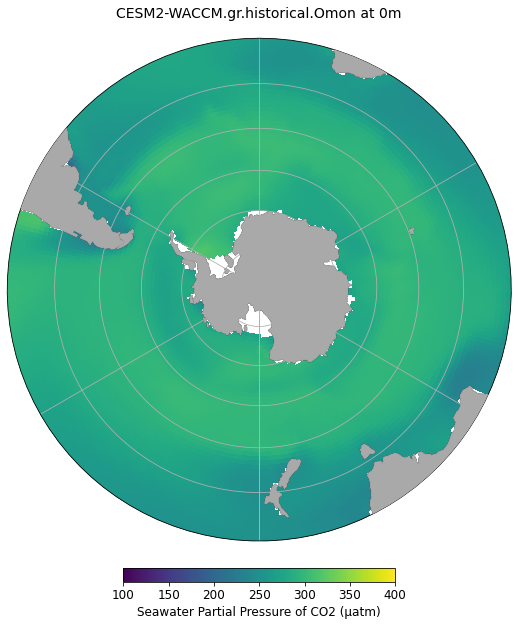

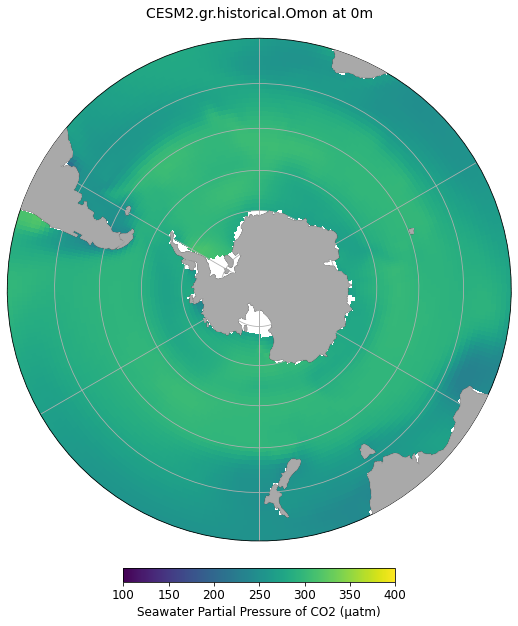

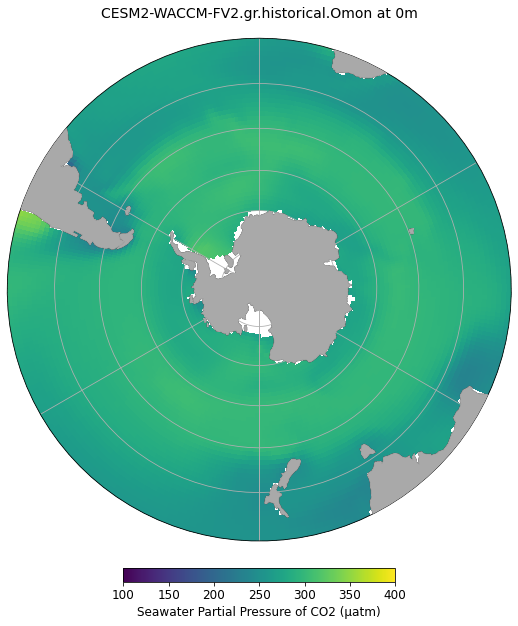

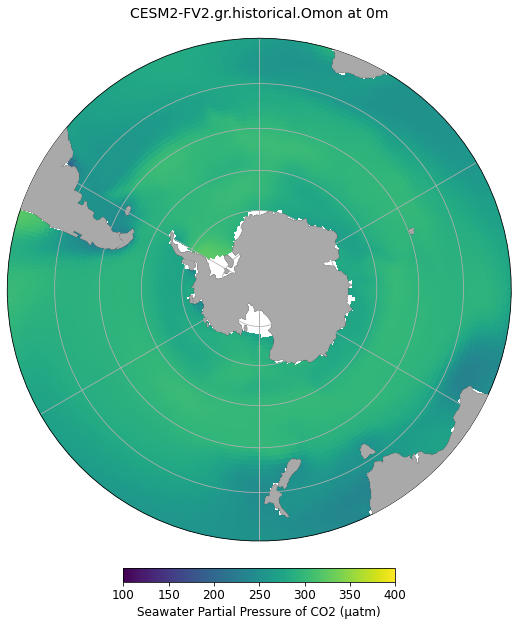

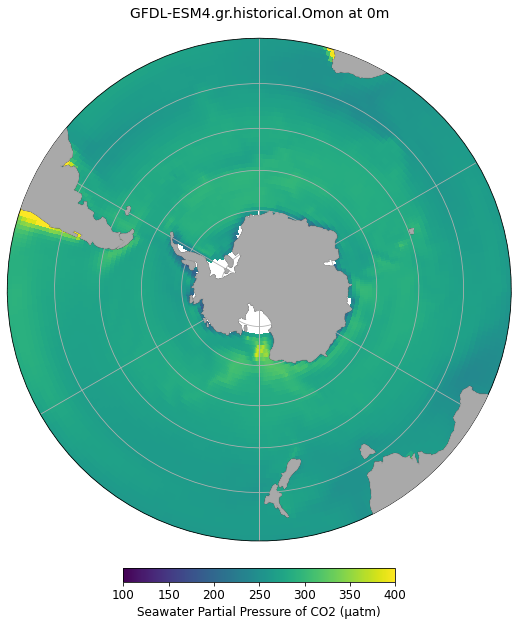

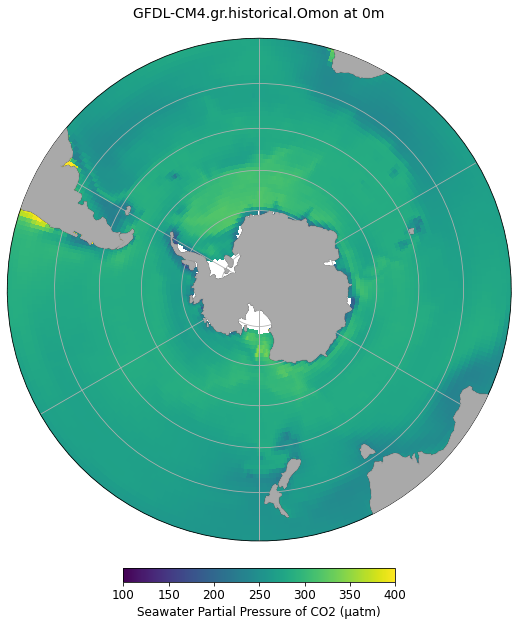

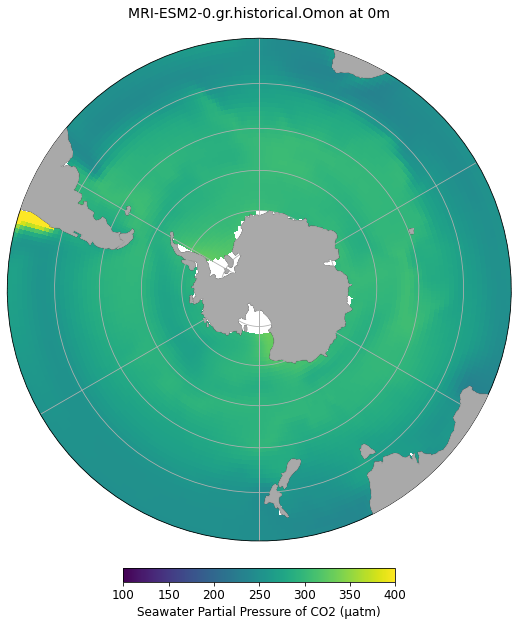

In [14]:
plt.rc('font', size = 12)
plt.rc('axes', titlesize= 10)    
plt.rc('axes', labelsize= 10)
plt.rc('figure', titlesize=14)

#loop over each key, value pair of the dictionary
ax_idx = 0 # index for your axes array
for name, ds in dd_new_new.items():

    ds = ds.isel(lev = 0)
    ds = ds.isel(time = slice(0, 239)).mean('time', keep_attrs=True)
    
    ds['pressure'] = xr.zeros_like(ds['thetao'])
#     print(ds['pressure'])
    ds['insitutemp'] = gsw.t_from_CT(ds['so'], ds['thetao'], ds['pressure']) 
#     print(ds['insitutemp'])
    conversion =  1e6/1035
    results = pyco2.sys(par1=ds.talk*conversion,par2=ds.dissic*conversion,par1_type=1,par2_type=2,
                    pressure_out=0, temperature_out = ds.thetao, pressure = ds['pressure'], 
                    temperature = ds['insitutemp'])
    ds['pco2_out'] = ds['talk'].copy(data=results['pCO2_out'])
    surf = ds.pco2_out
#     print(surf)
    lat = ds.lat.transpose('y','x')
# #     print(lat)
    lon = ds.lon.transpose('y','x')
    draw_SOcustom(lon,lat,surf,cmap='viridis',cbar_label='Seawater Partial Pressure of CO2 (\u03BCatm)',
                  title=name+ ' at 0m',
                  plot_type='pcolormesh',clims=[200,350])

#     ax_idx += 1 # this is a nifty python trick to increment a variable by one


#### 10m

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.

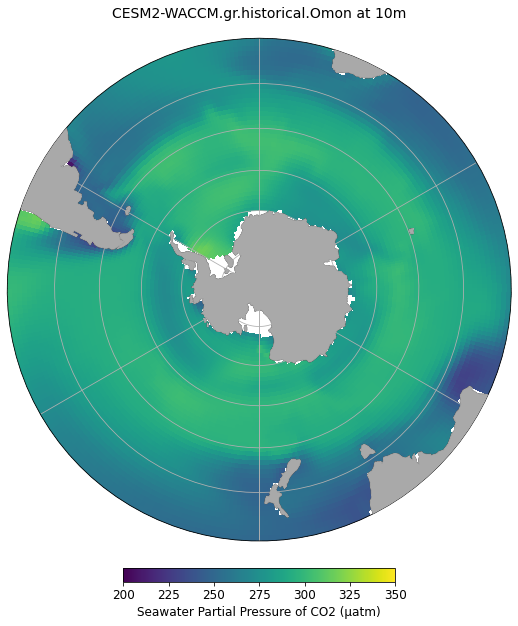

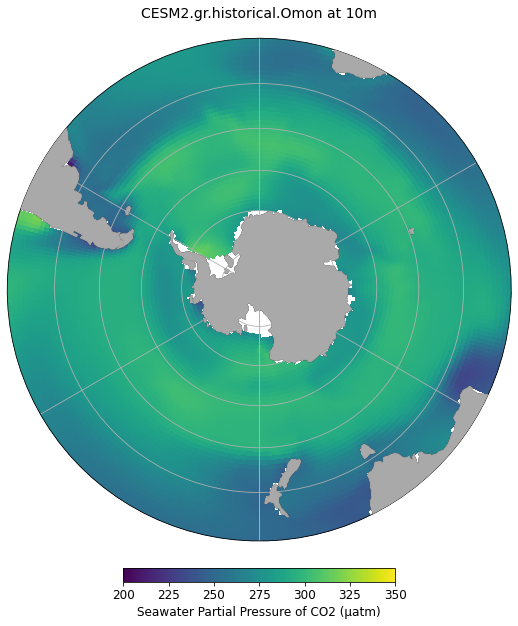

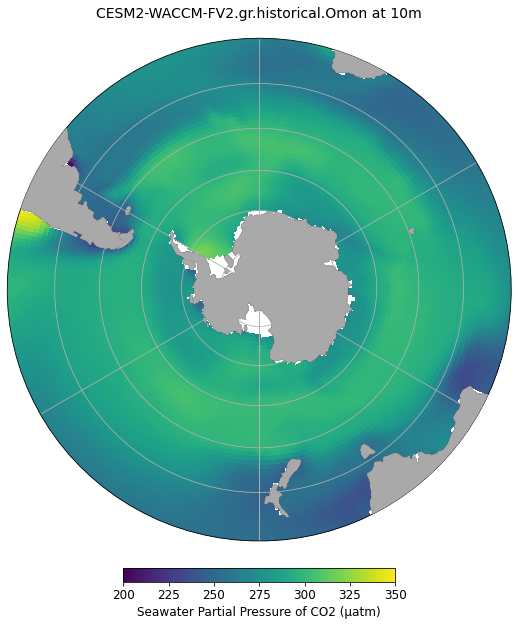

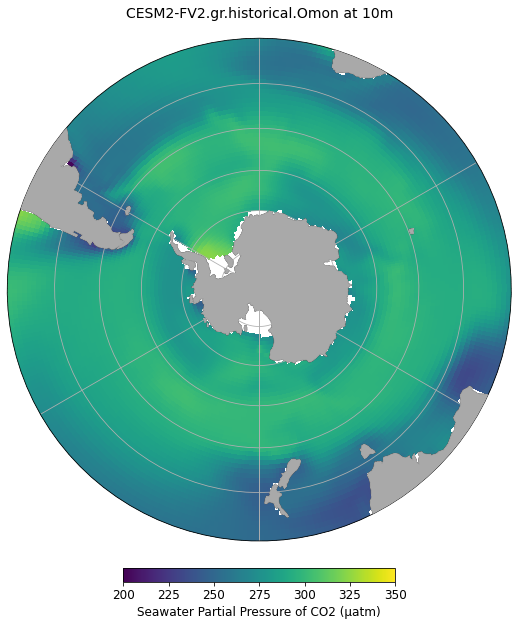

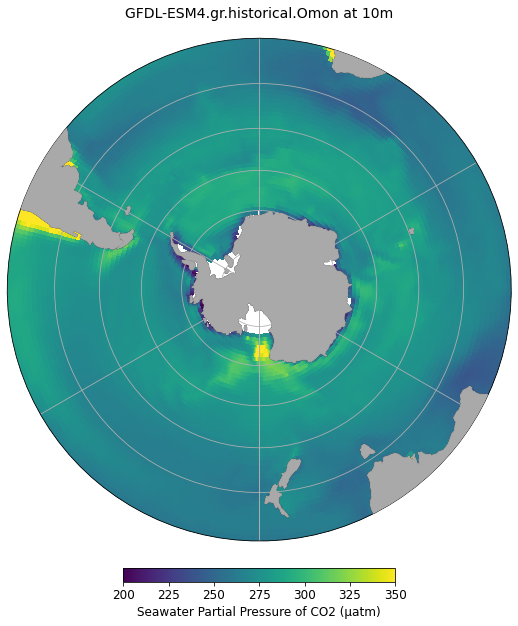

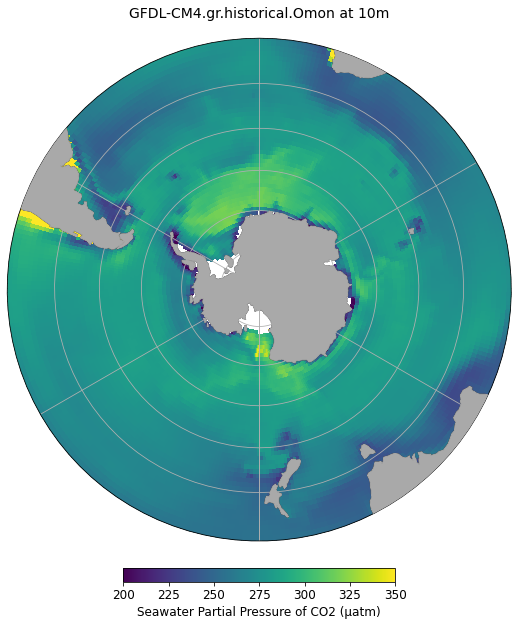

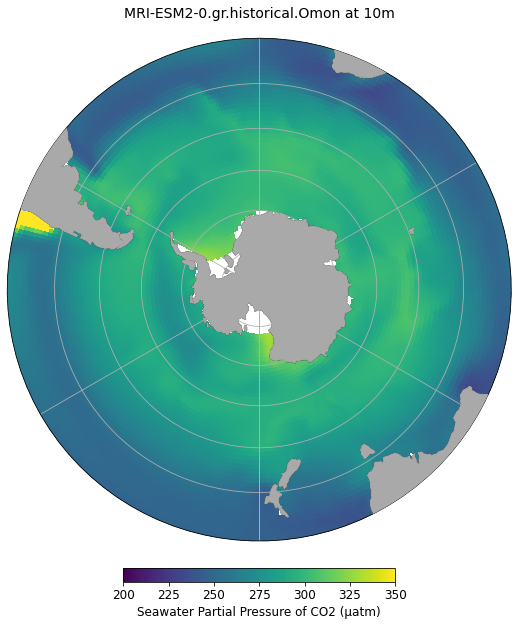

In [15]:
plt.rc('font', size = 12)
plt.rc('axes', titlesize= 10)    
plt.rc('axes', labelsize= 10)
plt.rc('figure', titlesize=14)

#loop over each key, value pair of the dictionary
ax_idx = 0 # index for your axes array
for name, ds in dd_new_new.items():

    ds = ds.isel(lev = 1)
    ds = ds.isel(time = slice(0, 239)).mean('time', keep_attrs=True)
    
    ds['pressure'] = xr.zeros_like(ds['thetao'])
#     print(ds['pressure'])
    ds['insitutemp'] = gsw.t_from_CT(ds['so'], ds['thetao'], ds['pressure']) 
#     print(ds['insitutemp'])
    conversion =  1e6/1035
    results = pyco2.sys(par1=ds.talk*conversion,par2=ds.dissic*conversion,par1_type=1,par2_type=2,
                    pressure_out=0, temperature_out = ds.thetao, pressure = ds['pressure'], 
                    temperature = ds['insitutemp'])
    ds['pco2_out'] = ds['talk'].copy(data=results['pCO2_out'])
    surf = ds.pco2_out
#     print(surf)
    lat = ds.lat.transpose('y','x')
# #     print(lat)
    lon = ds.lon.transpose('y','x')
    draw_SOcustom(lon,lat,surf,cmap='viridis',cbar_label='Seawater Partial Pressure of CO2 (\u03BCatm)',
                  title=name+ ' at 10m',
                  plot_type='pcolormesh',clims=[200,350])

#     ax_idx += 1 # this is a nifty python trick to increment a variable by one

#### 100m

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.

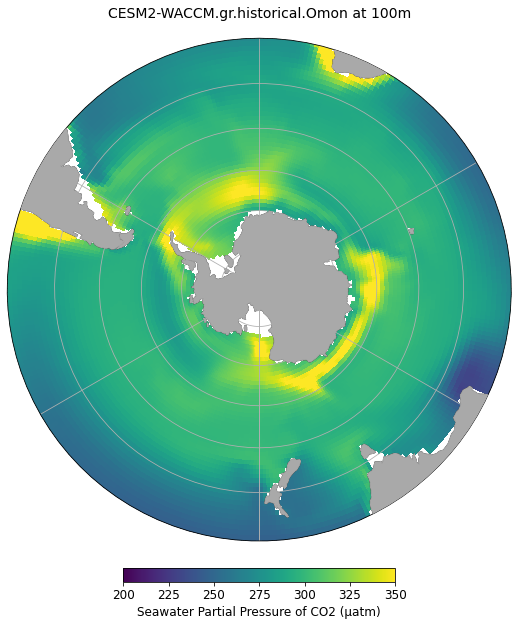

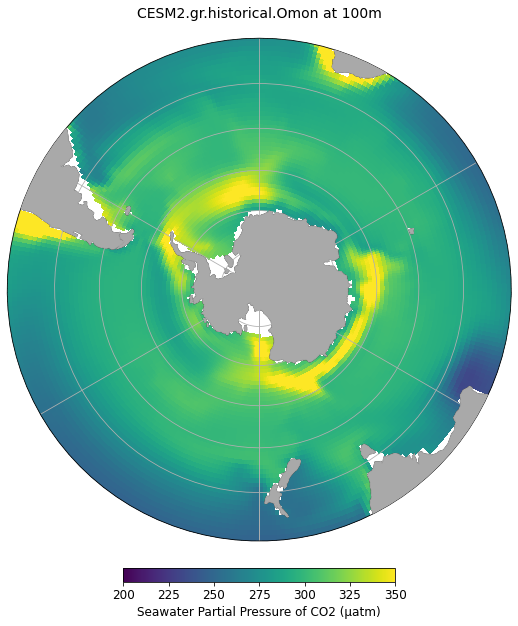

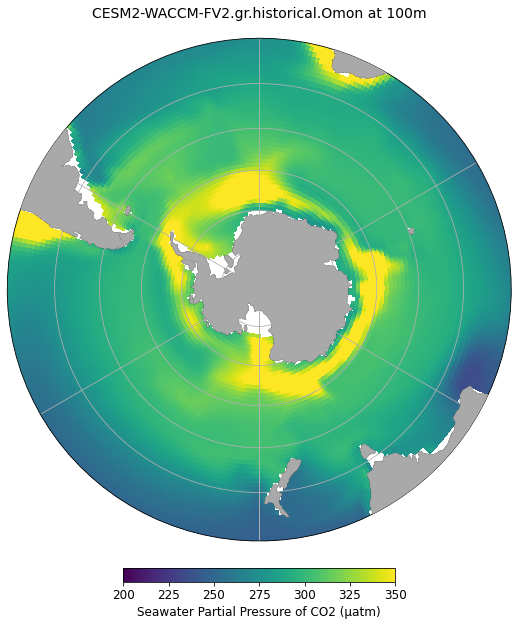

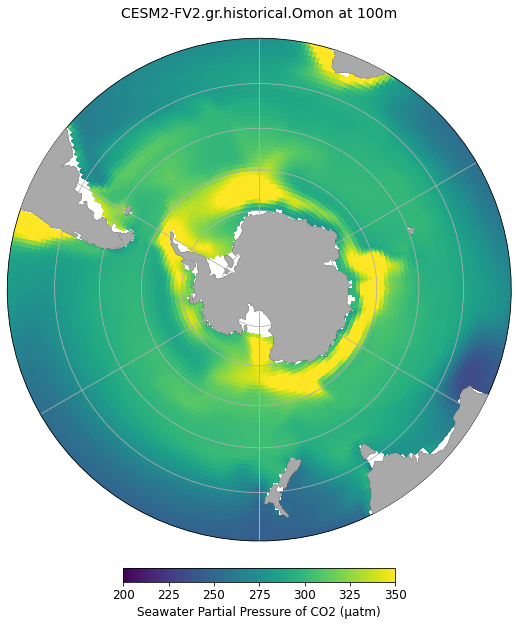

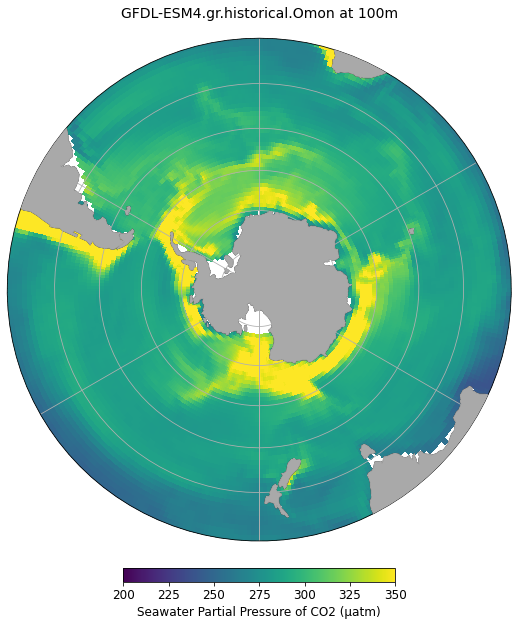

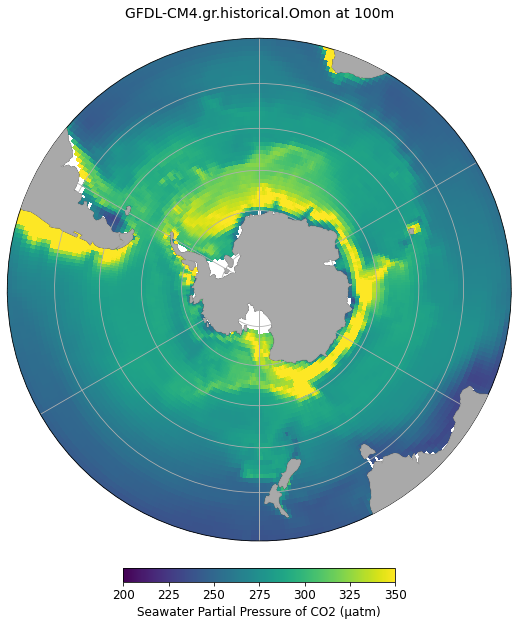

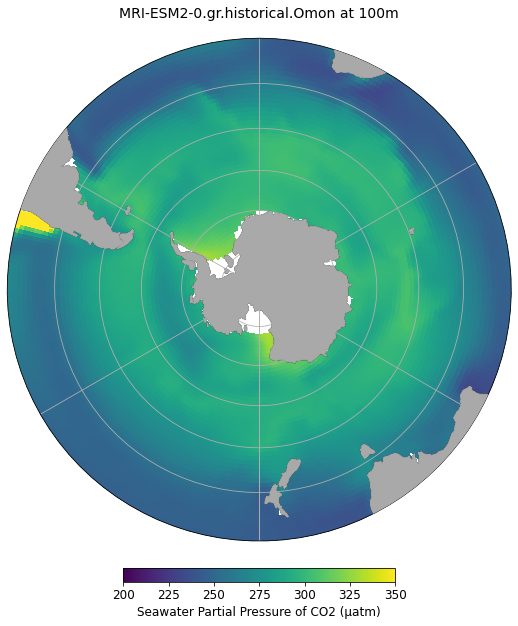

In [16]:
plt.rc('font', size = 12)
plt.rc('axes', titlesize= 10)    
plt.rc('axes', labelsize= 10)
plt.rc('figure', titlesize=14)

#loop over each key, value pair of the dictionary
ax_idx = 0 # index for your axes array
for name, ds in dd_new_new.items():

    ds = ds.isel(lev = 6)
    ds = ds.isel(time = slice(0, 239)).mean('time', keep_attrs=True)
    
    ds['pressure'] = xr.zeros_like(ds['thetao'])
#     print(ds['pressure'])
    ds['insitutemp'] = gsw.t_from_CT(ds['so'], ds['thetao'], ds['pressure']) 
#     print(ds['insitutemp'])
    conversion =  1e6/1035
    results = pyco2.sys(par1=ds.talk*conversion,par2=ds.dissic*conversion,par1_type=1,par2_type=2,
                    pressure_out=0, temperature_out = ds.thetao, pressure = ds['pressure'], 
                    temperature = ds['insitutemp'])
    ds['pco2_out'] = ds['talk'].copy(data=results['pCO2_out'])
    surf = ds.pco2_out
#     print(surf)
    lat = ds.lat.transpose('y','x')
# #     print(lat)
    lon = ds.lon.transpose('y','x')
    draw_SOcustom(lon,lat,surf,cmap='viridis',cbar_label='Seawater Partial Pressure of CO2 (\u03BCatm)',
                  title=name+ ' at 100m',
                  plot_type='pcolormesh',clims=[200,350])

#     ax_idx += 1 # this is a nifty python trick to increment a variable by one

#### 200m

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.

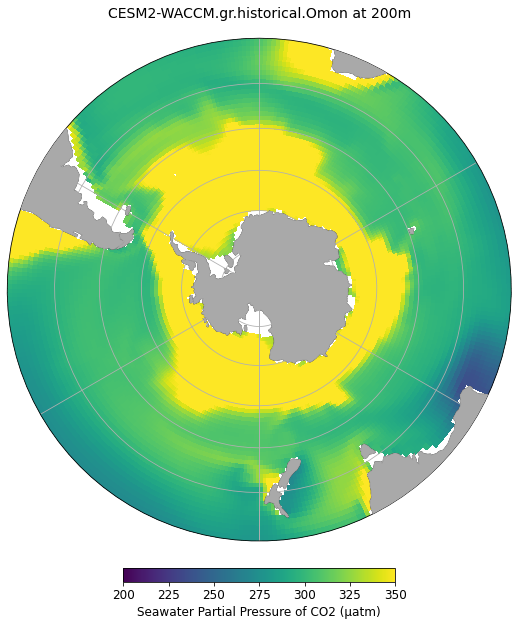

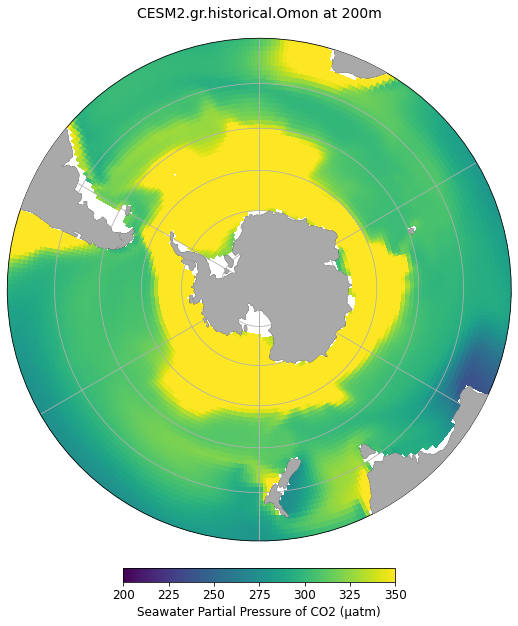

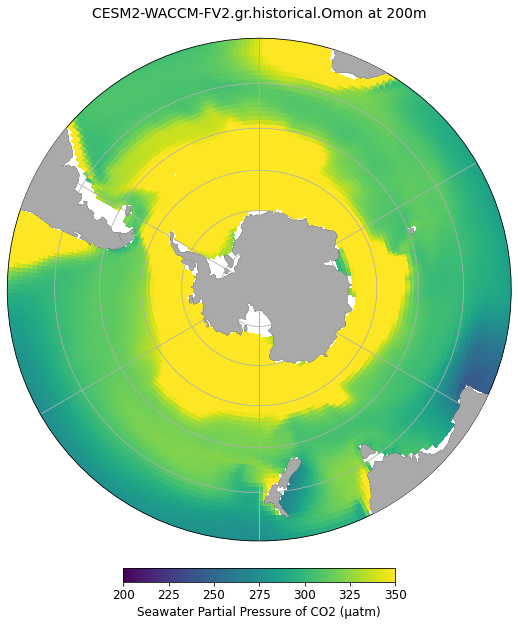

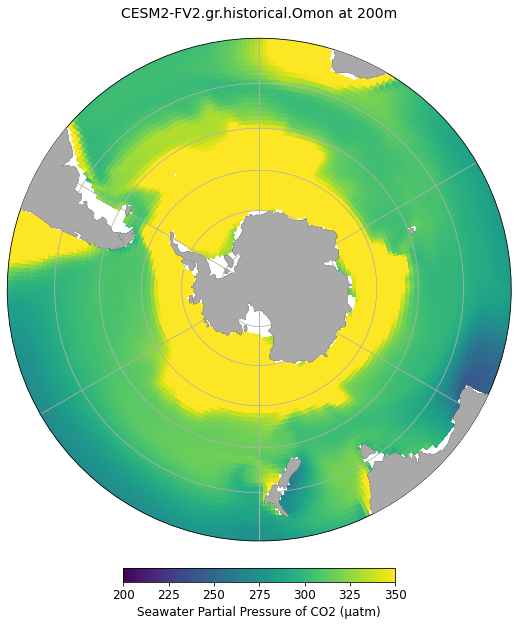

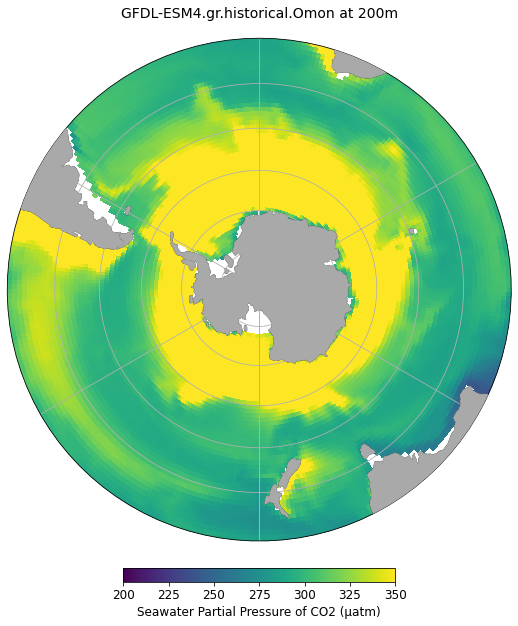

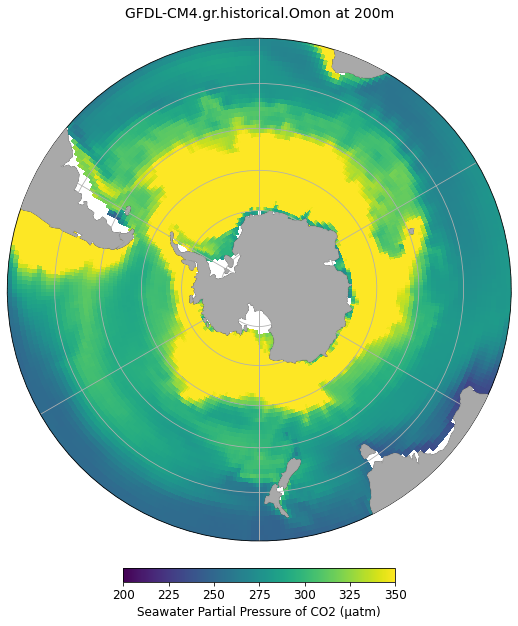

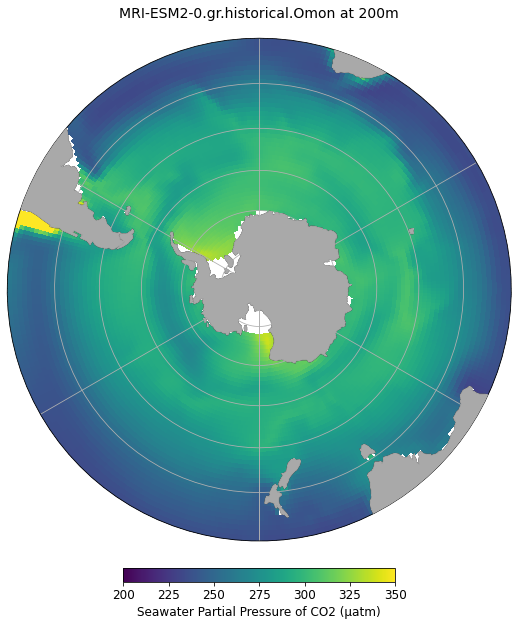

In [17]:
plt.rc('font', size = 12)
plt.rc('axes', titlesize= 10)    
plt.rc('axes', labelsize= 10)
plt.rc('figure', titlesize=14)

#loop over each key, value pair of the dictionary
ax_idx = 0 # index for your axes array
for name, ds in dd_new_new.items():

    ds = ds.isel(lev = 9)
    ds = ds.isel(time = slice(0, 239)).mean('time', keep_attrs=True)
    
    ds['pressure'] = xr.zeros_like(ds['thetao'])
#     print(ds['pressure'])
    ds['insitutemp'] = gsw.t_from_CT(ds['so'], ds['thetao'], ds['pressure']) 
#     print(ds['insitutemp'])
    conversion =  1e6/1035
    results = pyco2.sys(par1=ds.talk*conversion,par2=ds.dissic*conversion,par1_type=1,par2_type=2,
                    pressure_out=0, temperature_out = ds.thetao, pressure = ds['pressure'], 
                    temperature = ds['insitutemp'])
    ds['pco2_out'] = ds['talk'].copy(data=results['pCO2_out'])
    surf = ds.pco2_out
#     print(surf)
    lat = ds.lat.transpose('y','x')
# #     print(lat)
    lon = ds.lon.transpose('y','x')
    draw_SOcustom(lon,lat,surf,cmap='viridis',cbar_label='Seawater Partial Pressure of CO2 (\u03BCatm)',
                  title=name+ ' at 200m',
                  plot_type='pcolormesh',clims=[200,350])

#     ax_idx += 1 # this is a nifty python trick to increment a variable by one

#### At least in this version, it looks like `ds_2.so`, `ds_2.thetao`, `ds_2.dissic`, and `ds_2.talk` all have the same dimensions
But it still fails so maybe that's not the issue

<xarray.Dataset>
Dimensions:        (bnds: 2, vertex: 4, x: 360, y: 180)
Coordinates: (12/14)
  * y              (y) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
    lat_bounds     (y, bnds, x) float64 dask.array<chunksize=(180, 2, 360), meta=np.ndarray>
    lev            float64 0.0
    lev_bounds     (bnds) float64 dask.array<chunksize=(2,), meta=np.ndarray>
  * x              (x) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
    lon_bounds     (x, bnds, y) float64 dask.array<chunksize=(360, 2, 180), meta=np.ndarray>
    ...             ...
  * bnds           (bnds) int64 0 1
    lon            (x, y) float64 0.5 0.5 0.5 0.5 ... 359.5 359.5 359.5 359.5
    lat            (x, y) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
    lon_verticies  (vertex, x, y) float64 dask.array<chunksize=(1, 360, 180), meta=np.ndarray>
    lat_verticies  (vertex, x, y) float64 dask.array<chunksize=(1, 360, 180), meta=np.ndarray>
  * vertex         (vertex) int64 0 1 2 3
Data variables:
    thetao         (y, x) float32 dask.array<chunksize=(180, 360), meta=np.ndarray>
    dissic         (y, x) float32 dask.array<chunksize=(180, 360), meta=np.ndarray>
    talk           (y, x) float32 dask.array<chunksize=(180, 360), meta=np.ndarray>
    so             (y, x) float32 dask.array<chunksize=(180, 360), meta=np.ndarray>
    pressure       (y, x) float32 dask.array<chunksize=(180, 360), meta=np.ndarray>
    insitutemp     (y, x) float64 dask.array<chunksize=(180, 360), meta=np.ndarray>
    pco2_out       (y, x) float64 nan nan nan nan ... 283.4 283.4 283.4 283.4
Attributes: (12/43)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   674885.0
    branch_time_in_parent:  10950.0
    case_id:                1559
    ...                     ...
    sub_experiment_id:      none
    table_id:               Omon
    variant_info:           CMIP6 CESM2-FV2 historical experiment (1850-2014)...
    variant_label:          r1i1p1f1
    version_id:             v20191120
    intake_esm_varname:     None

In [15]:
ds_2.thetao

<xarray.DataArray 'thetao' (lev: 33, y: 180, x: 360)>
dask.array<getitem, shape=(33, 180, 360), dtype=float32, chunksize=(33, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lev      (lev) float64 0.0 10.0 20.0 30.0 ... 4e+03 4.5e+03 5e+03 5.5e+03
  * x        (x) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
    time     object 1950-01-15 12:00:00
    lon      (x, y) float64 0.5 0.5 0.5 0.5 0.5 ... 359.5 359.5 359.5 359.5
    lat      (x, y) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
Attributes: (12/19)
    cell_measures:  area: areacello volume: volcello
    cell_methods:   area: mean where sea time: mean
    comment:        Model data on the 1x1 grid includes values in all cells f...
    description:    Diagnostic should be contributed even for models using co...
    frequency:      mon
    id:             thetao
    ...             ...
    time_label:     time-mean
    time_title:     Temporal mean
    title:          Sea Water Potential Temperature
    type:           real
    units:          degC
    variable_id:    thetao

In [16]:
ds_2.dissic

<xarray.DataArray 'dissic' (lev: 33, y: 180, x: 360)>
dask.array<getitem, shape=(33, 180, 360), dtype=float32, chunksize=(33, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lev      (lev) float64 0.0 10.0 20.0 30.0 ... 4e+03 4.5e+03 5e+03 5.5e+03
  * x        (x) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
    time     object 1950-01-15 12:00:00
    lon      (x, y) float64 0.5 0.5 0.5 0.5 0.5 ... 359.5 359.5 359.5 359.5
    lat      (x, y) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
Attributes: (12/19)
    cell_measures:  area: areacello volume: volcello
    cell_methods:   area: mean where sea time: mean
    comment:        Model data on the 1x1 grid includes values in all cells f...
    description:    Dissolved inorganic carbon (CO3+HCO3+H2CO3) concentration
    frequency:      mon
    id:             dissic
    ...             ...
    time_label:     time-mean
    time_title:     Temporal mean
    title:          Dissolved Inorganic Carbon Concentration
    type:           real
    units:          mol m-3
    variable_id:    dissic

In [17]:
ds_2.talk

<xarray.DataArray 'talk' (lev: 33, y: 180, x: 360)>
dask.array<getitem, shape=(33, 180, 360), dtype=float32, chunksize=(33, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lev      (lev) float64 0.0 10.0 20.0 30.0 ... 4e+03 4.5e+03 5e+03 5.5e+03
  * x        (x) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
    time     object 1950-01-15 12:00:00
    lon      (x, y) float64 0.5 0.5 0.5 0.5 0.5 ... 359.5 359.5 359.5 359.5
    lat      (x, y) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
Attributes: (12/19)
    cell_measures:  area: areacello volume: volcello
    cell_methods:   area: mean where sea time: mean
    comment:        Model data on the 1x1 grid includes values in all cells f...
    description:    total alkalinity equivalent concentration (including carb...
    frequency:      mon
    id:             talk
    ...             ...
    time_label:     time-mean
    time_title:     Temporal mean
    title:          Total Alkalinity
    type:           real
    units:          mol m-3
    variable_id:    talk

Calculation for pressure

Looks pretty much identical to `p_1`

In [18]:
p_2 = gsw.p_from_z(-1*ds_2['lev'], ds_2['y'], geo_strf_dyn_height=0, sea_surface_geopotential=0)
p_2

<xarray.DataArray 'lev' (lev: 33, y: 180)>
array([[   0.        ,    0.        ,    0.        , ...,    0.        ,
           0.        ,    0.        ],
       [  10.10878369,   10.10875107,   10.10868588, ...,   10.10868588,
          10.10875107,   10.10878369],
       [  20.21806351,   20.21799827,   20.21786787, ...,   20.21786787,
          20.21799827,   20.21806351],
       ...,
       [4597.82290111, 4597.80791945, 4597.77797463, ..., 4597.77797463,
        4597.80791945, 4597.82290111],
       [5114.56464682, 5114.54796467, 5114.51462097, ..., 5114.51462097,
        5114.54796467, 5114.56464682],
       [5632.44231346, 5632.42392403, 5632.38716786, ..., 5632.38716786,
        5632.42392403, 5632.44231346]])
Coordinates:
  * lev      (lev) float64 0.0 10.0 20.0 30.0 ... 4e+03 4.5e+03 5e+03 5.5e+03
    time     object 1950-01-15 12:00:00
  * y        (y) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5

In situ temp

Diff dimensions that `insitutemp_1` (has x dimension) but otherwise *seems* fine


In [19]:
insitutemp_2 = gsw.t_from_CT(ds_2['so'], ds_2['thetao'], p_2) 
insitutemp_2

<xarray.DataArray 'so' (lev: 33, y: 180, x: 360)>
dask.array<t_from_ct, shape=(33, 180, 360), dtype=float64, chunksize=(33, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lev      (lev) float64 0.0 10.0 20.0 30.0 ... 4e+03 4.5e+03 5e+03 5.5e+03
  * x        (x) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
    time     object 1950-01-15 12:00:00
    lon      (x, y) float64 0.5 0.5 0.5 0.5 0.5 ... 359.5 359.5 359.5 359.5
    lat      (x, y) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
Attributes: (12/19)
    cell_measures:  area: areacello volume: volcello
    cell_methods:   area: mean where sea time: mean
    comment:        Model data on the 1x1 grid includes values in all cells f...
    description:    Sea water salinity is the salt content of sea water, ofte...
    frequency:      mon
    id:             so
    ...             ...
    time_label:     time-mean
    time_title:     Temporal mean
    title:          Sea Water Salinity
    type:           real
    units:          0.001
    variable_id:    so

# OOF

In [20]:
conversion =  1e6/1035
results_2 = pyco2.sys(par1=ds_2.talk*conversion,par2=ds_2.dissic*conversion,par1_type=1,par2_type=2,
                    pressure_out=0, temperature_out = ds_2.thetao, pressure = p_2, 
                    temperature = insitutemp_2)
results_2

PyCO2SYS error: input shapes cannot be broadcast together.


AttributeError: 'NoneType' object has no attribute 'keys'

## X Slice

In [21]:
ds_1 = dd_new_new['CESM2-FV2.gr.historical.Omon'].isel(time=1200).sel(x=slice(180,200)).mean('x',keep_attrs=True)


In [22]:
ds_1.so

<xarray.DataArray 'so' (lev: 33, y: 180)>
dask.array<mean_agg-aggregate, shape=(33, 180), dtype=float32, chunksize=(33, 180), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lev      (lev) float64 0.0 10.0 20.0 30.0 ... 4e+03 4.5e+03 5e+03 5.5e+03
    time     object 1950-01-15 12:00:00
Attributes: (12/19)
    cell_measures:  area: areacello volume: volcello
    cell_methods:   area: mean where sea time: mean
    comment:        Model data on the 1x1 grid includes values in all cells f...
    description:    Sea water salinity is the salt content of sea water, ofte...
    frequency:      mon
    id:             so
    ...             ...
    time_label:     time-mean
    time_title:     Temporal mean
    title:          Sea Water Salinity
    type:           real
    units:          0.001
    variable_id:    so

In [23]:
ds_1.thetao

<xarray.DataArray 'thetao' (lev: 33, y: 180)>
dask.array<mean_agg-aggregate, shape=(33, 180), dtype=float32, chunksize=(33, 180), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lev      (lev) float64 0.0 10.0 20.0 30.0 ... 4e+03 4.5e+03 5e+03 5.5e+03
    time     object 1950-01-15 12:00:00
Attributes: (12/19)
    cell_measures:  area: areacello volume: volcello
    cell_methods:   area: mean where sea time: mean
    comment:        Model data on the 1x1 grid includes values in all cells f...
    description:    Diagnostic should be contributed even for models using co...
    frequency:      mon
    id:             thetao
    ...             ...
    time_label:     time-mean
    time_title:     Temporal mean
    title:          Sea Water Potential Temperature
    type:           real
    units:          degC
    variable_id:    thetao

In [24]:
ds_1.dissic

<xarray.DataArray 'dissic' (lev: 33, y: 180)>
dask.array<mean_agg-aggregate, shape=(33, 180), dtype=float32, chunksize=(33, 180), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lev      (lev) float64 0.0 10.0 20.0 30.0 ... 4e+03 4.5e+03 5e+03 5.5e+03
    time     object 1950-01-15 12:00:00
Attributes: (12/19)
    cell_measures:  area: areacello volume: volcello
    cell_methods:   area: mean where sea time: mean
    comment:        Model data on the 1x1 grid includes values in all cells f...
    description:    Dissolved inorganic carbon (CO3+HCO3+H2CO3) concentration
    frequency:      mon
    id:             dissic
    ...             ...
    time_label:     time-mean
    time_title:     Temporal mean
    title:          Dissolved Inorganic Carbon Concentration
    type:           real
    units:          mol m-3
    variable_id:    dissic

In [25]:
ds_1.talk

<xarray.DataArray 'talk' (lev: 33, y: 180)>
dask.array<mean_agg-aggregate, shape=(33, 180), dtype=float32, chunksize=(33, 180), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lev      (lev) float64 0.0 10.0 20.0 30.0 ... 4e+03 4.5e+03 5e+03 5.5e+03
    time     object 1950-01-15 12:00:00
Attributes: (12/19)
    cell_measures:  area: areacello volume: volcello
    cell_methods:   area: mean where sea time: mean
    comment:        Model data on the 1x1 grid includes values in all cells f...
    description:    total alkalinity equivalent concentration (including carb...
    frequency:      mon
    id:             talk
    ...             ...
    time_label:     time-mean
    time_title:     Temporal mean
    title:          Total Alkalinity
    type:           real
    units:          mol m-3
    variable_id:    talk

In [26]:
p_1 = gsw.p_from_z(-1*ds_1['lev'], ds_1['y'], geo_strf_dyn_height=0, sea_surface_geopotential=0)
p_1

<xarray.DataArray 'lev' (lev: 33, y: 180)>
array([[   0.        ,    0.        ,    0.        , ...,    0.        ,
           0.        ,    0.        ],
       [  10.10878369,   10.10875107,   10.10868588, ...,   10.10868588,
          10.10875107,   10.10878369],
       [  20.21806351,   20.21799827,   20.21786787, ...,   20.21786787,
          20.21799827,   20.21806351],
       ...,
       [4597.82290111, 4597.80791945, 4597.77797463, ..., 4597.77797463,
        4597.80791945, 4597.82290111],
       [5114.56464682, 5114.54796467, 5114.51462097, ..., 5114.51462097,
        5114.54796467, 5114.56464682],
       [5632.44231346, 5632.42392403, 5632.38716786, ..., 5632.38716786,
        5632.42392403, 5632.44231346]])
Coordinates:
  * lev      (lev) float64 0.0 10.0 20.0 30.0 ... 4e+03 4.5e+03 5e+03 5.5e+03
    time     object 1950-01-15 12:00:00
  * y        (y) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5

In [27]:
insitutemp_1 = gsw.t_from_CT(ds_1['so'], ds_1['thetao'], p_1) 
insitutemp_1

<xarray.DataArray 'so' (lev: 33, y: 180)>
dask.array<t_from_ct, shape=(33, 180), dtype=float64, chunksize=(33, 180), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lev      (lev) float64 0.0 10.0 20.0 30.0 ... 4e+03 4.5e+03 5e+03 5.5e+03
    time     object 1950-01-15 12:00:00
Attributes: (12/19)
    cell_measures:  area: areacello volume: volcello
    cell_methods:   area: mean where sea time: mean
    comment:        Model data on the 1x1 grid includes values in all cells f...
    description:    Sea water salinity is the salt content of sea water, ofte...
    frequency:      mon
    id:             so
    ...             ...
    time_label:     time-mean
    time_title:     Temporal mean
    title:          Sea Water Salinity
    type:           real
    units:          0.001
    variable_id:    so

In [29]:
print(ds_1['talk'].copy(data=results_1['pCO2_out']))

<xarray.DataArray 'talk' (lev: 33, y: 180)>
array([[         nan,          nan,          nan, ..., 309.44352178,
        309.50128487, 309.3143347 ],
       [         nan,          nan,          nan, ..., 309.44460043,
        309.50219954, 309.31686714],
       [         nan,          nan,          nan, ..., 309.44678642,
        309.50517289, 309.31860388],
       ...,
       [         nan,          nan,          nan, ...,          nan,
                 nan,          nan],
       [         nan,          nan,          nan, ...,          nan,
                 nan,          nan],
       [         nan,          nan,          nan, ...,          nan,
                 nan,          nan]])
Coordinates:
  * y        (y) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lev      (lev) float64 0.0 10.0 20.0 30.0 ... 4e+03 4.5e+03 5e+03 5.5e+03
    time     object 1950-01-15 12:00:00
Attributes: (12/19)
    cell_measures:  area: areacello volume: volcello
    cell_methods:   area

In [16]:
print('\u03BC')

μ
